# Spatial Variable Selection

In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from interpret.glassbox import ExplainableBoostingClassifier
import geopandas as gpd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
data=gpd.read_file('Data/SUs.shp')
data['x']=data.geometry.centroid.x
data['y']=data.geometry.centroid.y
coordinates=data[["x","y"]].values

## Data - preprocessing

In [3]:
litho = ['Lit3', 'Lit5', 'Lit6', 'Lit10', 'Lit12', 'Lit16', 'Lit17']
data['litho'] = data[litho].idxmax(axis=1)
data['litho']=data.litho.astype('category')
lcover=['LC1','LC2', 'LC3', 'LC4', 'LC5', 'LC7']
data['lcover']=data[lcover].idxmax(axis=1)
data['lcover']=data.lcover.astype('category')
soil=['Soil1', 'Soil2','Soil3', 'Soil4', 'Soil5', 'Soil6', 'Soil7', 'Soil8']
data['soil'] = data[soil].idxmax(axis=1)
data['soil']=data.soil.astype('category')
data['Catchment']=data.Catchment.astype('category')

In [4]:
cov_forced=['Delta_mean','rain30day','Catchment','AreaSU']
cov_to_select=['Slope_mean','Slope_std', 'Curv_mean', 'PrCur_mean','PlCur_mean',
     'North_mean', 'East_mean', 'Spi_mean', 'Twi_mean','CA_mean', 'CS_mean','litho','lcover','soil']
cov=cov_forced+cov_to_select
X=data[cov]
data['Landslide'] = data['Landslide'].replace(np.nan, 0)
y=data.Landslide

## Clustering

In [5]:
from sklearn.cluster import KMeans
kmeans = KMeans(init="random",n_clusters=5,n_init=10,max_iter=300,random_state=42)
kmeans.fit(coordinates)
data['cluster']=kmeans.labels_
num_folds=len(np.unique(kmeans.labels_, return_counts=True)[0])

## Variable selection

In [6]:
unique,counts=np.unique(y, return_counts=True)
n_classes=2
w_0=len(y)/(n_classes*counts[0])
w_1=len(y)/(n_classes*counts[1])

In [7]:
# STEPFORWARD var selection

results_auc={}
# Initialize an empty list to store the selected features
selected_auc_features = cov_forced
# Initialize an empty list to store the AUC values of the selected features
selected_auc_values = []
# Define the list of candidate features
candidate_auc_features=cov_to_select
# Loop over the candidate features
ebm1 = ExplainableBoostingClassifier(n_jobs=-1,outer_bags=30, min_samples_leaf=2, validation_size=0.2,
                                     interactions=[(0,1)],exclude=[1])
auc_scores=[]
for i in tqdm (range(len(candidate_auc_features))):
    auc_dict = {}
    for feature in candidate_auc_features:
        features = selected_auc_features + [feature]
        
        for fold in range(0,num_folds):
            train_index=data.index[data['cluster']!=fold].tolist()
            val_index=data.index[data['cluster']==fold].tolist()
            X_train=X.loc[train_index]
            y_train=y.loc[train_index]
            X_val=X.loc[val_index]
            y_val=y.loc[val_index]
            sample_weights = np.empty(len(y_train))
            sample_weights[y_train == 0] = w_0
            sample_weights[y_train == 1] = w_1
            ebm1.fit(X_train[features], y_train,sample_weight=sample_weights)
            y_pred=ebm1.predict_proba(X_val[features])[:, 1]
            auc = roc_auc_score(y_val, y_pred)
            auc_scores.append(auc)
        mean_auc=np.mean(auc_scores)
        std_auc=np.std(auc_scores)
        # Add the AUC score to the dictionary
        auc_dict[feature] = mean_auc
    # Select the candidate feature with the highest AUC value
    auc_series = pd.Series(auc_dict)
    best_auc_feature = auc_series.idxmax()
    best_auc_value = auc_dict[best_auc_feature]
    # Add the best feature to the list of selected features
    selected_auc_features.append(best_auc_feature)
    # Add the AUC value of the best feature to the list of selected AUC values
    selected_auc_values.append(best_auc_value)
   
    # Save the selected feature names and their corresponding AUC values using pickle
    results_auc[i] = {'Selected Features': selected_auc_features.copy(),'MEAN AUC Score': auc_dict[best_auc_feature],
                     'STD AUC score': std_auc}
    # Remove the best feature from the list of candidate features
    candidate_auc_features.remove(best_auc_feature)
with open('Variable_Selection/variable_selection.pkl', 'wb') as f:
        pickle.dump(results_auc, f)

  0%|          | 0/14 [00:00<?, ?it/s]

## Plot

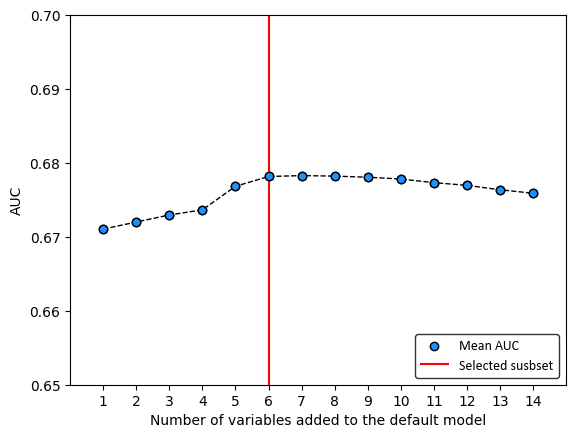

In [11]:
file_svs = 'Variable_Selection/variable_selection.pkl'
results_auc= pickle.load(open(file_svs, 'rb'))
import matplotlib.font_manager as font_manager

step_idx_auc = []
mean_auc = []
std_auc=[]
for index, values in results_auc.items():
    step_idx_auc.append(index)
    mean_auc.append(values['MEAN AUC Score'])
    std_auc.append(values['STD AUC score'])
step_arr=np.array(step_idx_auc)
features=step_arr+1

plt.plot(features,mean_auc,color='black',linestyle='--', marker='o',linewidth=1)
plt.scatter(features,mean_auc,color='dodgerblue',edgecolor='black',label='Mean AUC',zorder=10)
plt.axvline(x=6,color='red',label='Selected susbset')
plt.ylim(0.65,0.7)
plt.xlim(0,15)
plt.xlabel('Number of variables added to the default model')
plt.ylabel('AUC')
plt.xticks(np.arange(min(features), max(features)+1, 1))
font = font_manager.FontProperties(family='Calibri', size=10)
leg=plt.legend(loc='lower right',prop=font)
leg.get_frame().set_edgecolor('black')
plt.savefig('Outputs/plots/variable_selection_zoom.png')
plt.show()